### Import des librairies et lecture des fichiers


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import re
import time

In [2]:
movies = pd.read_csv("movies_metadata.csv")
ratings = pd.read_csv("ratings_small.csv")
keywords = pd.read_csv("keywords.csv")
credits = pd.read_csv("tmdb_5000_credits.csv")
link = pd.read_csv("links_small.csv")

C:\Users\VICTOR\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
movies.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


### Nettoyage de la base de données et réduction de la matrice aux caractéristiques interéssantes

Suppression des id incorrects, des valeurs abérrantes, des lignes avec NaN, et modification des valeurs pour les rendre plus faciles à traiter.

On sélectionne les attributs de films qui semblent pertinents pour différencier les films sur leur contenu.
Ces choix sont arbitraires et on pourra être amenés à réfléchir dessus et à les modifier.

In [4]:
def filter_correct_id(word): # MEILLEURE VERSION ICI
    if not isinstance(word, str) or re.fullmatch(r'[0-9]+', word):
        return word
    return "wrong_id"

On supprime les films dont l'id n'est pas un int, puis on change le type de l'attribut id : il passe de str à int64.

In [5]:
movies = movies.drop_duplicates('id')
keywords = keywords.drop_duplicates('id')
credits = credits.drop_duplicates('movie_id')
ratings = ratings.drop_duplicates('movieId') #Les notes ne nous intéressent pas ici mais on veut connaitre les films notés
#movies = movies[~movies.id.duplicated()]
#keywords = keywords[~keywords.id.duplicated()]
movies.id = movies.id.apply(filter_correct_id)
movies = movies[movies.id != "wrong_id"]
movies.id = movies.id.astype('int64')

Nous ne voulons garder que les films ayant reçu une note. Cela est une manière de ne garder qu'un nombre limité de films (il est très compliqué pour nous d'effectuer des calculs pour 45 000 films). De plus le clustering est intéressant pour renforcer la recommendation "user-based". On ne garde donc que les films ayant été notés par les utilisateurs. Ensuite on rajoute l'attribut keywords aux films.

In [6]:
movies = movies.rename(columns={'id' : 'tmdbId'})
keywords = keywords.rename(columns={'id' : 'tmdbId'})
credits = credits.rename(columns={'movie_id' : 'tmdbId'})
#movies = movies.merge(ratings, how='inner')
#movies = movies.join(link.set_index('movieId'), on='movieId', how='inner')

In [7]:
print(len(movies))
print(len(ratings))
print(len(link))
print(len(credits))
print(len(keywords))

45433
9066
9125
4803
45432


Jointure entre movies et link (pour faire le lien entre tmdbId dans movies et movieId dans ratings).

In [8]:
movies = movies.join(link.set_index('tmdbId'), on='tmdbId', how='inner')

In [9]:
len(movies)

9082

On ne garde que les films ayant reçu une note.

In [10]:
movies = movies.merge(ratings, how='inner')

In [11]:
len(movies)

9025

In [12]:
credits = credits [['tmdbId','crew']]

Jointure avec credits pour avoir aussi le crew

In [13]:
movies = movies.join(credits.set_index('tmdbId'), on='tmdbId', how='inner')

In [14]:
len(movies)

3394

Et enfin jointure avec keywords

In [15]:
movies = movies.join(keywords.set_index('tmdbId'), on='tmdbId', how='inner')

In [16]:
len(movies)

3394

Les clusters de films seront basés sur certains attributs. On ne garde que ceux qui nous intéressent pour comparer les films, à savoir le genre, les mots-clés, la date de sortie, les pays producteurs, la langue originale et la durée du film.

In [17]:
movies.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage',
       'tmdbId', 'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count', 'movieId', 'imdbId', 'userId', 'rating',
       'timestamp', 'crew', 'keywords'],
      dtype='object')

In [18]:
title_id = movies[['tmdbId','movieId','title']]
cluster_features = movies[['title','movieId', 'genres', 'keywords','crew', 'release_date', 'production_countries', 'original_language', 'runtime']]
cluster_features = cluster_features.dropna()
cluster_features.head()

,title,movieId,genres,keywords,crew,release_date,production_countries,original_language,runtime
0,Toy Story,1,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...","[{""credit_id"": ""52fe4284c3a36847f8024f55"", ""de...",1995-10-30,"[{'iso_3166_1': 'US', 'name': 'United States o...",en,81.0
9,GoldenEye,10,"[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...","[{'id': 701, 'name': 'cuba'}, {'id': 769, 'nam...","[{""credit_id"": ""52fe426ec3a36847f801e16f"", ""de...",1995-11-16,"[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",en,130.0
10,The American President,11,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...","[{'id': 833, 'name': 'white house'}, {'id': 84...","[{""credit_id"": ""52fe44dac3a36847f80adfa3"", ""de...",1995-11-17,"[{'iso_3166_1': 'US', 'name': 'United States o...",en,106.0
13,Nixon,14,"[{'id': 36, 'name': 'History'}, {'id': 18, 'na...","[{'id': 840, 'name': 'usa president'}, {'id': ...","[{""credit_id"": ""52fe43c59251416c7501d705"", ""de...",1995-12-22,"[{'iso_3166_1': 'US', 'name': 'United States o...",en,192.0
14,Cutthroat Island,15,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...","[{'id': 911, 'name': 'exotic island'}, {'id': ...","[{""credit_id"": ""52fe42f4c3a36847f802f69f"", ""de...",1995-12-22,"[{'iso_3166_1': 'FR', 'name': 'France'}, {'iso...",en,119.0


Dans une optique de simplification, on ne va considérer que les films "normaux" pour nos clusters. On donc va enlever les outsiders, à savoir les films d'une durée trop grande ou trop petite et ceux pour lesquels ces champs n'ont pas été renseignés.

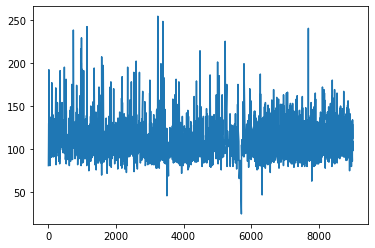

In [20]:
plt.plot(movies.runtime)

On choisit de ne retenir que les films d'une durée comprise entre 40 minutes et 4 heures.

In [21]:
cluster_features = cluster_features[cluster_features.runtime >= 40]
cluster_features = cluster_features[cluster_features.runtime <= 240]

On regarde la proportion de films pour lesquels certains champs n'ont pas été renseignés.

In [22]:
print("Nombre de films retenus dans cluster_features : ", len(cluster_features))
print("Parmi ces films :")
print(len(cluster_features[cluster_features.genres == "[]"]), "n'ont pas de genres")
print(len(cluster_features[cluster_features.keywords == "[]"]), "n'ont pas de keywords")
print(len(cluster_features[cluster_features.production_countries == "[]"]), "n'ont pas de production_countries")
print(len(cluster_features[cluster_features.crew == "[]"]), "n'ont pas de crew")

Nombre de films retenus dans cluster_features :  3390
Parmi ces films :
1 n'ont pas de genres
110 n'ont pas de keywords
24 n'ont pas de production_countries
0 n'ont pas de crew


Il s'agit d'une petite proportion, on peut donc retirer ces films problématiques.

In [23]:
cluster_features = cluster_features[cluster_features.genres != "[]"]
cluster_features = cluster_features[cluster_features.keywords != "[]"]
cluster_features = cluster_features[cluster_features.production_countries != "[]"]
print("Nombre de films dans cluster_features : ", len(cluster_features))

Nombre de films dans cluster_features :  3265


On peut maintenant se concentrer sur le traitement des données de chacune des colonnes. Il faut les simplifier au maximum pour rendre possible la comparaison de films basée sur ces attributs.

In [24]:
def vectorize_genres(genres):
    
    if isinstance(genres, str):
        pattern = re.compile(r"'id': [0-9]*")
        return np.array([int(w[6:]) for w in pattern.findall(genres)])
    
    return genres

cluster_features.genres = cluster_features.genres.apply(vectorize_genres)

In [25]:
def vectorize_keywords(keywords):
    
    if isinstance(keywords, str):
        pattern = re.compile(r"'id': [0-9]*")
        return np.array([int(w[6:]) for w in pattern.findall(keywords)])
    
    return keywords

cluster_features.keywords = cluster_features.keywords.apply(vectorize_keywords)

In [26]:
def find_director(crew):
    
    if isinstance(crew, str):
        start = crew.find('\"Director\"')+21
        new = crew[start:]
        end = new.find("\"")
        director = new[:end]
        return director
    
    return crew

cluster_features = cluster_features.rename(columns={'crew' : 'director'})
cluster_features.director = cluster_features.director.apply(find_director)

In [27]:
def simplify_date(date):
    
    if isinstance(date, str):
        return int(date[:4])
    
    return date

cluster_features.release_date = cluster_features.release_date.apply(simplify_date)

In [28]:
def simplify_countries(countries):
    
    if isinstance(countries, str):
        pattern = re.compile(r"'iso_3166_1': ...")
        return [w[15:] for w in pattern.findall(countries)]
    
    return genres

cluster_features.production_countries = cluster_features.production_countries.apply(simplify_countries)

In [29]:
cluster_features.head()

,title,movieId,genres,keywords,director,release_date,production_countries,original_language,runtime
0,Toy Story,1,"[16, 35, 10751]","[931, 4290, 5202, 6054, 9713, 9823, 165503, 17...",John Lasseter,1995,[US],en,81.0
9,GoldenEye,10,"[12, 28, 53]","[701, 769, 1308, 2812, 3268, 3272, 3278, 3376,...",Martin Campbell,1995,"[GB, US]",en,130.0
10,The American President,11,"[35, 18, 10749]","[833, 840, 1605, 33476, 211505]",Rob Reiner,1995,[US],en,106.0
13,Nixon,14,"[36, 18]","[840, 2946, 4240, 5565, 6086, 6165]",Oliver Stone,1995,[US],en,192.0
14,Cutthroat Island,15,"[28, 12]","[911, 1454, 1969, 3799, 5470, 12988]",Renny Harlin,1995,"[FR, DE, IT, US]",en,119.0


### Définition d'une distance sur les films

In [30]:
MAX_YEAR_DIFFERENCE = max(cluster_features.release_date) - min(cluster_features.release_date)
MAX_RUNTIME_DIFFERENCE = max(cluster_features.runtime) - min(cluster_features.runtime)

Cette fonction calcule les similarités entre 2 films. Plus les valeurs sont proches de 0, plus les films ont de points communs et plus elles sont proches de 1, plus ils sont différents (peut-être changer le nom ? instinctivement, j'aurais pensé que pour être très similaire il fallait un score élevé REPONSE : il s'agit d'une distance)

discuter de la manière de les calculer ?

In [31]:
def movie_distance(m1, m2, w_gen=3, w_key=4, w_dir=4, w_rel=2, w_pro=2, w_ori=1, w_run=1):
    
    sum_vect = 0
    # SIMILARITIES IN GENRES
    g1 = m1.genres
    g2 = m2.genres
    gen = np.append(g1, g2)
    sum_vect += (w_gen * (1 - (len(gen) - len(np.unique(gen))) / min(len(g1), len(g2)))) ** 2
        
    # SIMILARITIES IN KEYWORDS
    kw1 = m1.keywords
    kw2 = m2.keywords
    kw = np.append(kw1, kw2)
    sum_vect += (w_key * (1 - (len(kw) - len(np.unique(kw))) / min(len(kw1), len(kw2)))) ** 2
    
    # SIMILARITIES FOR THE DIRECTOR
    if m1.director != m2.director:
        sum_vect += (w_dir * 1) ** 2  # CHANGER PEUT ETRE
        
    #SIMILARITIES FOR THE RELEASE DATE
    sum_vect += (w_rel * abs(m1.release_date - m2.release_date) / MAX_YEAR_DIFFERENCE) ** 2
    
    #SIMILARITIES IN PRODUCTION COUNTRIES
    pc = []
    pc1 = m1.production_countries
    pc.extend(pc1)
    pc2 = m2.production_countries
    pc.extend(pc2)
    pc_dist = 1 - (len(pc) - len(np.unique(pc))) / min(len(pc1), len(pc2))
    if 'US' not in pc1 and 'US' not in pc2 and pc_dist > 0.5:
        sum_vect += (w_pro * 0.5) ** 2
    else:
        sum_vect += (w_pro * pc_dist) ** 2
    
    #SIMILARITIES FOR THE LANGUAGE
    lang1 = m1.original_language
    lang2 = m2.original_language
    if lang1 != lang2 :
        if lang1 != 'en' and lang2 != 'en':
            sum_vect += (w_ori * 0.4) ** 2
        else:
            sum_vect += (w_ori * 1) ** 2
    
    #SIMILARITIES FOR THE RUNTIME
    sum_vect += (w_run * abs(m1.runtime - m2.runtime) / MAX_RUNTIME_DIFFERENCE) ** 2
    
    return np.sqrt(sum_vect)

La fonction compute_dist_matrix calcule la distance séparant chaque paire de films du DataFrame passé en argument. Cependant elle ne renvoit pas une matrice, mais un pd Series avec un double index (l'id de 2 films).

In [32]:
def compute_dist_matrix(clu_fea):
    
    movies_id = clu_fea.movieId.apply(lambda x: str(x))
    dist_mat = pd.DataFrame(np.nan * len(clu_fea), index=movies_id, columns=movies_id)
    for i in range(len(clu_fea)):
        for j in range(i, len(clu_fea)):
            if i == j:
                dist_mat.iat[i, j] = 1000
            else:
                dist_mat.iat[i, j] = dist_mat.iat[j, i] = movie_distance(clu_fea.iloc[i], clu_fea.iloc[j]) # ICI
    
    return dist_mat

On s'intéresse ici au Agglomerative Hierarchical Clustering. On n'a pas besoin de préciser le nombre de clusters attendus, à la place on obtient un dendrogramme.

In [33]:
class dendrogram:
    def __init__(self, leaf=None):
        self.leaf = leaf
        self.leaf_nb = 1
        self.father = None
        self.left = None
        self.right = None
    
    def set_leaf_nb(self):
        total_leaf_nb = 0
        if self.left is not None:
            total_leaf_nb += self.left.leaf_nb
        if self.right is not None:
            total_leaf_nb += self.right.leaf_nb
        self.leaf_nb = max(1, total_leaf_nb)
    
    def get_id_list(self):
        id_list = []
        def prefix(node):
            if node.leaf is not None:
                id_list.append(node.leaf)
            else:
                prefix(node.right)
                prefix(node.left)
        prefix(self)
        
        return id_list
    
    def get_root(self):
        tmp = self
        while tmp.father is not None: tmp = tmp.father
            
        return tmp
    
    def get_n_clusters(self, n):
        cluster_list = []
        outliers = []
        error = []
        def step(node, n):
            if n == 1:
                cluster_list.append(node.get_id_list())
            elif node.left is None or node.right is None:
                error.append(True)
            else:
                prop_left = node.left.leaf_nb / node.leaf_nb
                prop_right = node.right.leaf_nb / node.leaf_nb
                if prop_left < 0.15:
                    outliers.extend(node.left.get_id_list())
                    step(node.right, n)
                elif prop_right < 0.15:
                    outliers.extend(node.right.get_id_list())
                    step(node.left, n)
                else:
                    n_left = max(1, round(n * prop_left))
                    if n_left == n:
                        n_left -= 1
                    n_right = n - n_left
                    step(node.left, n_left)
                    step(node.right, n_right)
        step(self, n)
        if error:
            print("n too big")
        else:
            return cluster_list, outliers

On ajoute un attributs dendrogram aux films sélectionnés. Au départ, chaque film est isolé. Ensuite on construit le dendrogramme étape par étape en connectant les films les plus proches (on les regroupe dans un même cluster).

In [70]:
clu_fea.movieId

0            1
9           10
10          11
13          14
14          15
         ...  
9006    160080
9007    160271
9008    160438
9010    160563
9011    160565
Name: movieId, Length: 3265, dtype: int64

In [34]:
def clusterize(dist_mat, clu_fea):
    
    clu_fea["dendrogram"] = clu_fea.movieId.apply(lambda x: dendrogram(leaf=x))
    size_mat = len(clu_fea)
    for cpt in range(1, size_mat):
        index_str1, index_str2 = dist_mat.stack().idxmin()
        index1, index2 = int(index_str1), int(index_str2)
        mov1 = clu_fea[clu_fea.movieId == index1].iloc[0]
        mov2 = clu_fea[clu_fea.movieId == index2].iloc[0]
        tmp1 = mov1.dendrogram
        tmp2 = mov2.dendrogram
        while tmp1.father is not None: tmp1 = tmp1.father
        while tmp2.father is not None: tmp2 = tmp2.father
        tmp3 = dendrogram()
        tmp3.left = tmp1
        tmp3.right = tmp2
        tmp3.set_leaf_nb()
        tmp1.father = tmp3
        tmp2.father = tmp3
        new_d = np.maximum(dist_mat.loc[index_str1, :], dist_mat.loc[index_str2, :])
        dist_mat.loc[index_str1, :] = dist_mat.loc[:, index_str1] = new_d
        dist_mat = dist_mat.drop(index_str2, axis=0)
        dist_mat = dist_mat.drop(index_str2, axis=1)
    
    return clu_fea.iloc[0].dendrogram.get_root()

In [35]:
def get_cluster(clu_fea, id_list):
    df = pd.DataFrame([])
    for i in id_list:
        df = df.append(clu_fea[clu_fea.movieId == i])
    
    return df

In [36]:
def get_clusters_size(clu_fea, id_list_list):
    for id_list in id_list_list:
        print(len(id_list))

In [51]:
clu_fea = cluster_features.copy()

In [62]:
pd.Series(dist_mat_test_10.index.values)

0    68157
1     6294
2     7980
3     1213
4    63853
5    54787
6     7444
7     5680
8    55250
9     2147
dtype: object

In [52]:
clu_fea["dendrogram"] = clu_fea.movieId.apply(lambda x: dendrogram(leaf=x))
clu_fea.head(1)

,title,movieId,genres,keywords,director,release_date,production_countries,original_language,runtime,dendrogram
0,Toy Story,1,"[16, 35, 10751]","[931, 4290, 5202, 6054, 9713, 9823, 165503, 17...",John Lasseter,1995,[US],en,81.0,<__main__.dendrogram object at 0x00000218E45FB...


Test sur un échantillon de taille 10

In [37]:
test_10 = cluster_features.sample(10)
start_time = time.time()
dist_mat_test_10 = compute_dist_matrix(test_10)
print("Temps d'execution : %s secondes ---" % (time.time() - start_time))

Temps d'execution : 0.028943777084350586 secondes ---


In [38]:
%load_ext line_profiler

In [39]:
start_time = time.time()
root_test_10 = clusterize(dist_mat_test_10.copy(), test_10)
print("Temps d'execution : %s secondes ---" % (time.time() - start_time))

Temps d'execution : 0.04255986213684082 secondes ---


Test sur un échantillon de taille 100

In [40]:
test_100 = cluster_features.sample(100)

In [41]:
start_time = time.time()
dist_mat_test_100 = compute_dist_matrix(test_100)
print("Temps d'execution : %s secondes ---" % (time.time() - start_time))

Temps d'execution : 2.558931350708008 secondes ---


In [42]:
%lprun -f movie_distance compute_dist_matrix(test_100)

*** KeyboardInterrupt exception caught in code being profiled.

In [43]:
start_time = time.time()
root_test_100 = clusterize(dist_mat_test_100.copy(), test_100)
print("Temps d'execution : %s secondes ---" % (time.time() - start_time))

Temps d'execution : 0.4029827117919922 secondes ---


In [44]:
%lprun -f clusterize clusterize(dist_mat_test_100.copy(), test_100)

In [45]:
clusters, outliers = root_test_100.get_n_clusters(5)
print(len(outliers), 'outliers')
get_clusters_size(cluster_features, clusters)

2 outliers
28
10
15
15
30


In [46]:
get_cluster(cluster_features, outliers)

,title,movieId,genres,keywords,director,release_date,production_countries,original_language,runtime
7106,Timecrimes,65642,"[878, 53]","[1435, 2135, 2483, 3667, 9720, 9887, 9935, 101...",Nacho Vigalondo,2007,[ES],es,92.0
6477,Severance,47937,"[27, 35, 53]","[2429, 15127, 207937, 220085, 220086, 220087]",Christopher Smith,2006,"[GB, DE, HU]",en,96.0


Données complètes

In [47]:
start_time = time.time()
dist_mat = compute_dist_matrix(cluster_features) # environ 45 minutes
print("Temps d'execution : %s secondes ---" % (time.time() - start_time))

KeyboardInterrupt: 

In [ ]:
start_time = time.time()
root = clusterize(dist_mat, cluster_features) # environ 15 minutes
print("Temps d'execution : %s secondes ---" % (time.time() - start_time))

In [ ]:
clusters, outliers = root.get_n_clusters(8)
print(len(outliers), 'outliers')
get_clusters_size(cluster_features, clusters)

In [ ]:
get_cluster(cluster_features, outliers)